### Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

import os, os.path
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import multivariate_normal
import scipy as sp
import scipy.stats as st
from scipy import interpolate

import sys
sys.path.append("..")
from ERTsim import PHert

import pickle as pkl


import pandas as pd

### Define Functions for Later

In [2]:
def sample_data(N,dmean,dstd):
    D_N = np.zeros((N,dmean.shape[0]))
    for i in range(dmean.shape[0]):
        D_N[:,i] = np.random.normal(dmean[i], dstd[i], N)
    return D_N
        
def train_reg(dtrain, vtrain):
    return RandomForestRegressor().fit(dtrain, vtrain)

def sample_posterior(reg, dtest, vtest_true, D_N, W):
    vtest_pred = reg.predict(dtest)
    vmeas_pred = reg.predict(D_N)

    postsamples = np.zeros(D_N.shape[0])
    for i in range(D_N.shape[0]):
        INDS = np.where(np.logical_and(vtest_pred>=vmeas_pred[i]-W, vtest_pred<=vmeas_pred[i]+W))
        csamples = vtest_true[INDS]
        try:
            sample_ind = np.random.choice(csamples.shape[0], 1)
            postsamples[i] = csamples[sample_ind]
        except:
            pass
        
        
    return postsamples

def compute_post_quantile(postsamples, truth):
    num_smaller = sum(postsamples <= truth)
    quantile = num_smaller / postsamples.shape[0]
    return quantile
    

# Import Measured Data (For Plotting Purposes Only)

In [3]:
sfile = '../data/PH-2018-srv.txt'
efile = '../data/PH-2018-eloc.txt'
srv = pd.read_csv(sfile,sep='\t',header=None)
elec = pd.read_csv(efile,sep='\t',header=None)

M = (elec.values[srv.values[:,2][:].astype(int)-1,1]+elec.values[srv.values[:,4][:].astype(int)-1,1])/2
C = (elec.values[srv.values[:,1][:].astype(int)-1,3]+elec.values[srv.values[:,3][:].astype(int)-1,3])/2 - (elec.values[srv.values[:,4][:].astype(int)-1,1]-elec.values[srv.values[:,2][:].astype(int)-1,1])/2



# Import Monte Carlo Data (Train/Test and Validation Sets)

In [4]:
valfolder = '../data/val/' #Validation set (x1000)
MCfolder = '../data/MC3/' #Train/test set (x2000)
rows = 11 #Number of header rows

### Train/Test Set

In [5]:
pfile = MCfolder + 'params.dat'

files = [name for name in os.listdir(MCfolder) if (os.path.isfile(MCfolder+name) and (name != "params.dat"))]
Nreal = len(files)

In [6]:
D = np.zeros((Nreal,15371))
inds = np.zeros(Nreal,dtype=int)
i = 0
for f in files:
    data = ert.ERTManager(MCfolder+f).data
    R = np.array([data('r')[i] for i in range(data('r').size())])
    D[i,:] = R
    f2 = f.split('_')[1]
    inds[i] = np.int(f2.split('.')[0])
    i = i+1


In [7]:
fullinput = pd.read_csv(pfile,skiprows=rows)
inputs = fullinput.values[inds,:]
fullinput

,dip,H,xpos,rho_fault,rho_back
0,101.833891,115.800812,412.011373,29.642176,49.316446
1,125.126511,174.696599,484.424341,27.897438,229.946475
2,109.386873,53.786238,456.523421,42.869513,72.535312
3,101.283646,126.145778,460.279214,26.864429,58.730871
4,84.311672,56.621057,432.695884,25.424708,68.864551
...,...,...,...,...,...
1995,135.779417,144.507231,406.534273,24.860789,84.199023
1996,125.967736,96.671548,375.001311,31.356123,81.066461
1997,92.215093,145.760068,370.331503,30.884901,85.394349
1998,115.140965,47.364446,405.448911,26.081312,205.104687


### Validation Set

In [8]:
pfile_val = valfolder + 'params.dat'

files_val = [name for name in os.listdir(valfolder) if (os.path.isfile(valfolder+name) and (name != "params.dat"))]
Nreal_val = len(files_val)

In [9]:
D_val = np.zeros((Nreal_val,15371))
inds_val = np.zeros(Nreal_val,dtype=int)
i = 0
for f in files_val:
    data = ert.ERTManager(valfolder+f).data
    R = np.array([data('r')[i] for i in range(data('r').size())])
    D_val[i,:] = R
    f2 = f.split('_')[1]
    inds_val[i] = np.int(f2.split('.')[0])
    i = i+1

In [10]:
fullinput = pd.read_csv(pfile_val,skiprows=rows)
inputs_val = fullinput.values[inds_val,:]
fullinput

,dip,H,xpos,rho_fault,rho_back
0,101.833891,115.932109,440.053241,25.921461,81.732329
1,125.126511,120.771175,423.888500,25.625185,85.709724
2,109.386873,193.983650,367.388974,26.248977,100.554072
3,101.283646,111.433334,472.048560,34.268329,112.545691
4,84.311672,100.039334,408.609619,36.421841,65.356405
...,...,...,...,...,...
995,38.674691,119.613711,378.916336,43.412423,107.754837
996,97.089108,48.113415,378.549194,28.696714,71.216461
997,156.377683,87.909873,448.393489,30.482685,48.328792
998,57.010517,127.728542,354.936423,26.349365,47.003912


# Add Noise to Monte Carlo Data (Train/Test Sets Only, for Now)

In [11]:
itrain = np.int(np.round(.5 * D.shape[0]))

DNew = np.zeros(D.shape)
for i in range(D.shape[0]):
    DNew[i,:] = sample_data(1,D[i,:],srv.values[:,6])
    
dmean = np.mean(DNew[:itrain,:],axis=0)
dstd = np.std(DNew[:itrain,:],axis=0)
DNew = (DNew-dmean)/dstd


# Train Random Forest Regression Inverse Models

In [12]:
mfile = 'models_NormNoise.pkl'
try:
    models = pkl.load(open( mfile, "rb" ))
except:    
    models = [None]*5
    for i in range(5):
        print('Training '+str(i+1)+' of 5')
        models[i] = train_reg(DNew[:itrain,:],inputs[:itrain,i])

    pkl.dump(models,open(mfile, "wb" ))

# For Each Realization in the Validation Set, Calculate the alpha-quantile

In [13]:
N = 10000
Ws = (2.5, 5, 5, 5, 10)

ntruths = D_val.shape[0]
# ntruths = 50
try:
    quantiles = pkl.load(open('quantiles_NormNoise.pkl',"rb"))
except:
    quantiles = np.ones((ntruths,5))*np.nan
    for i in range(ntruths):
        print('Sampling '+str(i+1)+' of '+str(ntruths))
        D_mean_true = D_val[i,:]
        D_sigma_true = srv.values[:,6]
#         D_N = sample_data(N, D_val[i,:],srv.values[:,6])
        D_N = (sample_data(N, D_mean_true, D_sigma_true) - dmean)/dstd

        for j in range(5):
            postsamples = sample_posterior(models[j], DNew[itrain+1:,:], inputs[itrain+1:,j], D_N, Ws[j])
            quantiles[i,j] = compute_post_quantile(postsamples, inputs_val[i,j])

    pkl.dump(quantiles,open('quantiles_NormNoise.pkl', "wb"))

# Plot alpha-quantile distributions

/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


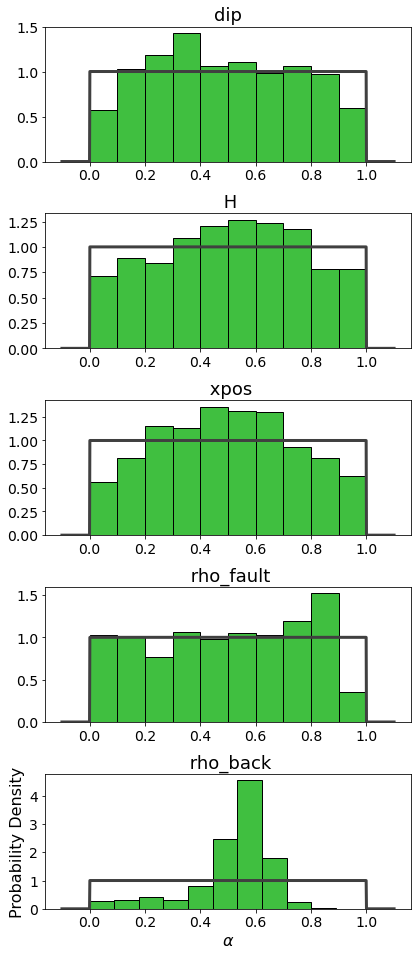

In [14]:
U = st.uniform(loc=0, scale=1)
Ux = np.linspace(-.1,1.1, 1000)
Up = U.pdf(Ux)

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=((6*1.23)*.8,(15*1.05)*.85))
for i in range(5):
    plt.subplot(511+i)
    plt.hist(quantiles[:,i],density=True,facecolor=(.25,.75,.25),edgecolor='k',label='Observed')
    plt.plot(Ux,Up,'-',color=(.25,.25,.25),linewidth=3,label='Theoretical')
    plt.title(fullinput.columns[i],fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    
    
# plt.subplot(511)
# plt.legend()

plt.subplot(515)
plt.ylabel('Probability Density',fontsize=16)
plt.xlabel(r'$\alpha$',fontsize=16)
fig.tight_layout()

/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


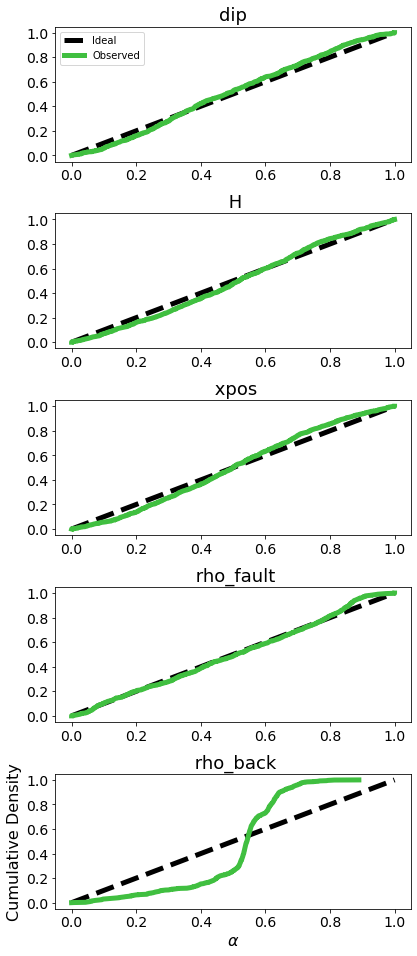

In [15]:
th = np.linspace(0,1,quantiles.shape[0])
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=((6*1.23)*.8,(15*1.05)*.85))
for i in range(5):
    qs = np.sort(quantiles[:,i])
    plt.subplot(511+i)
    plt.plot(th,th,'--k',linewidth=5,label='Ideal')
    plt.plot(qs,th,color=(.25,.75,.25),linewidth=5,label='Observed')
    plt.title(fullinput.columns[i],fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    
    
plt.subplot(511)
plt.legend()

plt.subplot(515)
plt.ylabel('Cumulative Density',fontsize=16)
plt.xlabel(r'$\alpha$',fontsize=16)
fig.tight_layout()